<a href="https://colab.research.google.com/github/matdcp/Data-dreamers-/blob/main/NEURAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Upload cleaned dataset


In [1]:
import pandas as pd
from google.colab import files

# Carica il file CSV
uploaded = files.upload()  # Ti verrà chiesto di selezionare il file dal tuo computer



Saving cleaned_dataset_NN.csv to cleaned_dataset_NN.csv


In [2]:
# Leggi il file CSV con Pandas
for filename in uploaded.keys():
    df = pd.read_csv(filename)

df.head()

,id,Start,End,Label
0,Ventricular,0,11,B-Multi-tissue_structure
1,fibrillation,12,24,O
2,long,32,36,O
3,QT,37,39,O
4,syndrome,40,48,O


#Splitting dataset

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Step 1: Creare il vocabolario dai token in 'id'
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df['id'])

# Dimensione del vocabolario
vocabulary_size = len(tokenizer.word_index) + 1  # +1 per includere il padding
print("Dimensione del vocabolario:", vocabulary_size)

# Convertire i token in ID numerici
X = tokenizer.texts_to_sequences(df['id'])

# Step 2: Codifica delle etichette
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Label'])  # Convertire in numeri
print("Mapping etichette:", dict(enumerate(label_encoder.classes_)))

# Convertire le etichette in one-hot encoding
y_one_hot = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

# Step 3: Splitting del dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Output per verifica
print(f"Train set: X={len(X_train)}, y={len(y_train)}")
print(f"Validation set: X={len(X_val)}, y={len(y_val)}")
print(f"Test set: X={len(X_test)}, y={len(y_test)}")


Dimensione del vocabolario: 11514
Mapping etichette: {0: 'B-Anatomical_system', 1: 'B-Cell', 2: 'B-Cellular_component', 3: 'B-Developing_anatomical_structure', 4: 'B-Immaterial_anatomical_entity', 5: 'B-Multi-tissue_structure', 6: 'B-Organ', 7: 'B-Organism_subdivision', 8: 'B-Organism_substance', 9: 'B-Pathological_formation', 10: 'B-Tissue', 11: 'I-Anatomical_system', 12: 'I-Cell', 13: 'I-Cellular_component', 14: 'I-Developing_anatomical_structure', 15: 'I-Immaterial_anatomical_entity', 16: 'I-Multi-tissue_structure', 17: 'I-Organ', 18: 'I-Organism_subdivision', 19: 'I-Organism_substance', 20: 'I-Pathological_formation', 21: 'I-Tissue', 22: 'O'}
Train set: X=42685, y=42685
Validation set: X=9147, y=9147
Test set: X=9147, y=9147


In [4]:
# Step 4: Applicare il padding alle sequenze
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Definire la lunghezza massima delle sequenze
max_sequence_len = 45  # Scegli una lunghezza adeguata al tuo dataset

# Applicare il padding
X_train_padded = pad_sequences(X_train, maxlen=max_sequence_len, padding='post')
X_val_padded = pad_sequences(X_val, maxlen=max_sequence_len, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=max_sequence_len, padding='post')

# Aggiornare X_train, X_val e X_test con le versioni "padded"
X_train = X_train_padded
X_val = X_val_padded
X_test = X_test_padded

# Verifica delle shape
print("Shape di X_train:", X_train.shape)
print("Shape di X_val:", X_val.shape)
print("Shape di X_test:", X_test.shape)


Shape di X_train: (42685, 45)
Shape di X_val: (9147, 45)
Shape di X_test: (9147, 45)


In [5]:
# **Step 5: Calcolo dei pesi di classe**
from sklearn.utils.class_weight import compute_class_weight

y_train_classes = np.argmax(y_train, axis=1)  # Converti y_train da one-hot encoding a classi
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_classes),
    y=y_train_classes
)

class_weights_dict = dict(enumerate(class_weights))
print("Pesi delle classi:", class_weights_dict)


Pesi delle classi: {0: 51.55193236714976, 1: 3.52826913539428, 2: 14.05961791831357, 3: 80.68998109640832, 4: 44.18737060041408, 5: 4.052116954623125, 6: 7.1379598662207355, 7: 17.508203445447087, 8: 9.819415688980907, 9: 7.110611360986174, 10: 14.84695652173913, 11: 84.35770750988142, 12: 6.0649332196646775, 13: 33.140527950310556, 14: 371.17391304347825, 15: 132.56211180124222, 16: 7.765144624340549, 17: 50.15863689776733, 18: 132.56211180124222, 19: 35.68979933110368, 20: 10.981476717262671, 21: 24.419336384439358, 22: 0.046940070445845444}


#Neural Network Approach
##Embedding  

###Vocabulary creation

In [6]:
# Mappatura parola->ID e ID->parola
word2id = tokenizer.word_index
id2word = {v: k for k, v in word2id.items()}

# Dimensione del vocabolario
vocab_size = len(word2id) + 1  # +1 per il padding
print("Dimensione del vocabolario:", vocab_size)
print("Esempio di vocabolario:", list(word2id.items())[:10])

Dimensione del vocabolario: 11514
Esempio di vocabolario: [('<OOV>', 1), ('1', 2), ('0', 3), ('5', 4), ('2', 5), ('patients', 6), ('3', 7), ('cells', 8), ('4', 9), ('6', 10)]


###Data preparation for Word2Vec

In [12]:
import random
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing.text import Tokenizer

# Raggruppare parole in sequenze (ad esempio, ogni 5 parole formano una frase)
sequence_length = 5
grouped_sequences = [' '.join(df['id'][i:i+sequence_length]) for i in range(0, len(df['id']), sequence_length)]
print("Esempio di sequenze raggruppate:", grouped_sequences[:5])

# Tokenizzazione delle sequenze raggruppate
new_wids = [[word2id[word] for word in sequence.split() if word in word2id] for sequence in grouped_sequences]
print(f"Numero di sequenze tokenizzate: {len(new_wids)}")

# Filtrare sequenze troppo corte
filtered_wids = [sequence for sequence in new_wids if len(sequence) > 1]
reduced_sequences = random.sample(filtered_wids, int(len(filtered_wids) * 0.1))
print(f"Numero di sequenze ridotte: {len(reduced_sequences)}")
# Generare skip-gram per ogni sequenza
skip_grams = [skipgrams(sequence, vocabulary_size=vocab_size, window_size=3) for sequence in reduced_sequences]

# Visualizzare alcune coppie di skip-gram
pairs, labels = skip_grams[0][0], skip_grams[0][1]
if len(pairs) > 0:
    print(f"Numero di coppie skip-gram nella prima sequenza: {len(pairs)}")
    for i in range(min(5, len(pairs))):  # Visualizza massimo 5 coppie
        print(f"({id2word[pairs[i][0]]} ({pairs[i][0]}), {id2word[pairs[i][1]]} ({pairs[i][1]})) -> {labels[i]}")
else:
    print("Nessuna coppia valida generata nella prima sequenza.")


Esempio di sequenze raggruppate: ['Ventricular fibrillation long QT syndrome', 'probably caused clindamycin Prolongation QT', 'time interval provoked limited number', 'drugs especially macrolide antibiotics describe', 'case QT time interval prolongation']
Numero di sequenze tokenizzate: 12196
Numero di sequenze ridotte: 1190
Numero di coppie skip-gram nella prima sequenza: 12
(respectively (112), size (414)) -> 0
(traits (3494), adenoma (6167)) -> 0
(respectively (112), traits (3494)) -> 1
(respectively (112), hpa (5961)) -> 0
(traits (3494), respectively (112)) -> 1


###Skip-gram model

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input, Dot, Dense, Reshape

# Parametri del modello
embedding_dim = 128  # Dimensione degli embedding

# Input per il token centrale
word_input = Input(shape=(1,), name="word_input")
word_embedding = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer="glorot_uniform"
)(word_input)
word_embedding = Reshape((embedding_dim,))(word_embedding)

# Input per il contesto
context_input = Input(shape=(1,), name="context_input")
context_embedding = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer="glorot_uniform"
)(context_input)
context_embedding = Reshape((embedding_dim,))(context_embedding)

# Prodotto scalare tra embedding (similitudine)
dot_product = Dot(axes=1)([word_embedding, context_embedding])

# Output: probabilità di essere una coppia positiva
output = Dense(1, activation="sigmoid")(dot_product)

# Creazione del modello
model = Model(inputs=[word_input, context_input], outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy")

# Visualizzare il riepilogo del modello
print(model.summary())


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ word_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ context_input             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 1, 128)         │      1,473,792 │ word_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 1, 128)         │      1,473,792 │ context_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 128)            │              0 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 128)            │              0 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_2 (Dot)               │ (None, 1)              │              0 │ reshape_4[0][0],       │
│                           │                        │                │ reshape_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │              2 │ dot_2[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,947,586 (11.24 MB)

 Trainable params: 2,947,586 (11.24 MB)

 Non-trainable params: 0 (0.00 B)

None


###Training model for embedding

In [14]:
def generate_batches(skip_grams, batch_size=512):
    for elem in skip_grams:
        pairs, labels = elem[0], elem[1]
        for i in range(0, len(pairs), batch_size):
            pair_first_elem = np.array([pair[0] for pair in pairs[i:i+batch_size]], dtype='int32')
            pair_second_elem = np.array([pair[1] for pair in pairs[i:i+batch_size]], dtype='int32')
            labels_batch = np.array(labels[i:i+batch_size], dtype='int32')
            yield [pair_first_elem, pair_second_elem], labels_batch

# Training
batch_size = 1024
epochs = 3
precomputed_batches = list(generate_batches(skip_grams, batch_size=batch_size))
for epoch in range(1, epochs + 1):
    loss = 0
    for X, Y in precomputed_batches:
        # Calcola i pesi di campionamento per ogni batch
        class_weights_batch = np.array([class_weights_dict[label] for label in Y], dtype='float32')

        # Addestra il modello usando i pesi di classe
        loss += model.train_on_batch(X, Y, sample_weight=class_weights_batch)
    print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")



KeyboardInterrupt: 

###Get word embeddings

In [94]:
# Filtra token significativi (alfabetici e lunghi almeno 3 caratteri)
significant_tokens = [token for token in tokens if token.isalpha() and len(token) > 2][:5]

print("Esempi di token significativi:", significant_tokens)

# Ottieni embedding per i token significativi
embedding_significant = embedding_df.loc[significant_tokens]
print("Embedding per i token significativi:")
print(embedding_significant)



Esempi di token significativi: ['patients', 'cells', 'study', 'cell', 'results']
Embedding per i token significativi:
               0         1         2         3         4         5    \
patients  0.012365 -0.020404 -0.005114 -0.022448  0.014575 -0.007469   
cells     0.020307 -0.014114 -0.017610 -0.011785  0.008511  0.012744   
study     0.014790  0.020223  0.004737 -0.007052  0.009892  0.000231   
cell      0.020257  0.015177 -0.014511 -0.005940  0.019215 -0.005357   
results   0.019211  0.022245 -0.004947 -0.009670 -0.019447  0.011934   

               6         7         8         9    ...       118       119  \
patients  0.012582 -0.017923 -0.008803 -0.015547  ...  0.003306  0.000987   
cells    -0.006556  0.014219  0.021180  0.008612  ...  0.014929 -0.009843   
study     0.009538  0.016890 -0.018927  0.011648  ... -0.022036  0.020915   
cell     -0.002983 -0.014073 -0.015700 -0.016491  ...  0.017418  0.016043   
results  -0.015325  0.017670 -0.000674  0.014438  ... -0.020498 

### Visualize word embeddings

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


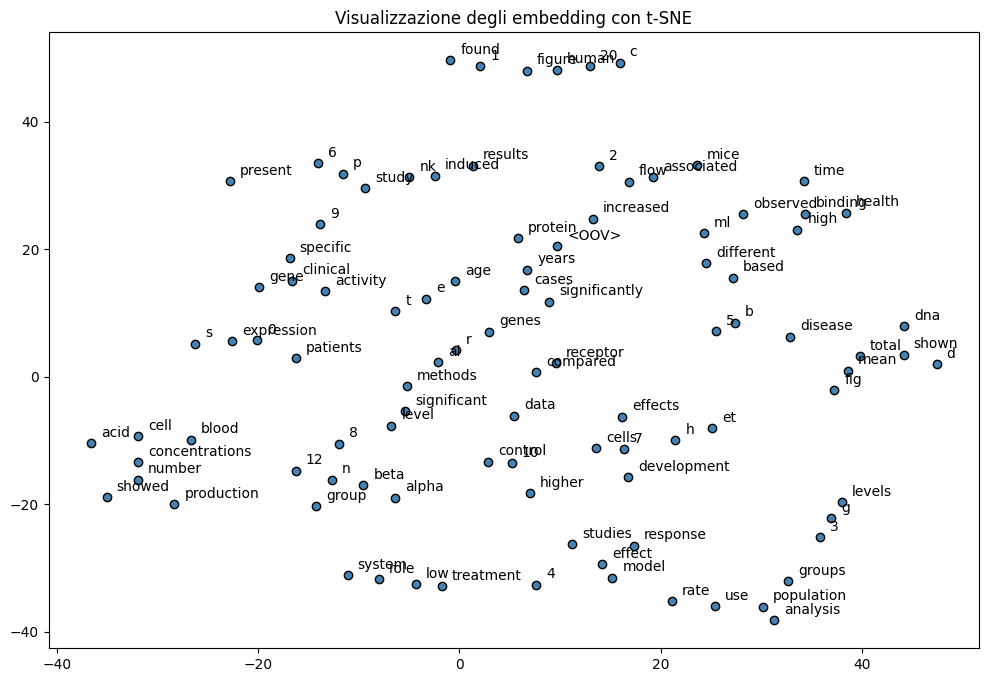

In [95]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Selezionare automaticamente un sottoinsieme di token significativi
# Ad esempio, i primi 50 token dal vocabolario (puoi modificare il numero)
num_tokens = 100  # Numero di token da visualizzare
selected_tokens = list(word2id.keys())[:num_tokens]
selected_ids = [word2id[token] for token in selected_tokens]

# Ottieni gli embedding per i token selezionati
selected_vectors = np.array([weights[idx] for idx in selected_ids])

# Riduzione dimensionale con t-SNE
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=5)
reduced_vectors = tsne.fit_transform(selected_vectors)

# Visualizzazione
plt.figure(figsize=(12, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(selected_tokens, reduced_vectors[:, 0], reduced_vectors[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
plt.title("Visualizzazione degli embedding con t-SNE")
plt.show()



##LSTM Model

In [96]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [97]:
# **2. Configurazione dei parametri**
embedding_dim = 128  # Dimensione degli embedding
max_sequence_len = 50  # Lunghezza massima delle sequenze
num_classes = len(label_encoder.classes_)  # Numero di classi target

# **3. Utilizzo degli embedding pre-addestrati**
embedding_matrix = np.zeros((vocab_size, embedding_dim))  # Matrix per gli embedding
for word, idx in word2id.items():
    if idx < vocab_size:
        embedding_matrix[idx] = weights[idx]  # Usa gli embedding pre-addestrati


In [100]:
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],  # Embedding pre-addestrati
              input_length=max_sequence_len,
              trainable=False),  # Non addestra gli embedding, li usa come statici
    LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])


model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │       1,473,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,473,792 (5.62 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,473,792 (5.62 MB)

None


In [103]:
print("Numero di classi previste nel modello:", len(np.unique(y_pred_classes)))
print("Numero di classi nei dati di test:", len(np.unique(y_true_classes)))
print("Numero di classi totali (label_encoder):", len(label_encoder.classes_))


Numero di classi previste nel modello: 1
Numero di classi nei dati di test: 22
Numero di classi totali (label_encoder): 23


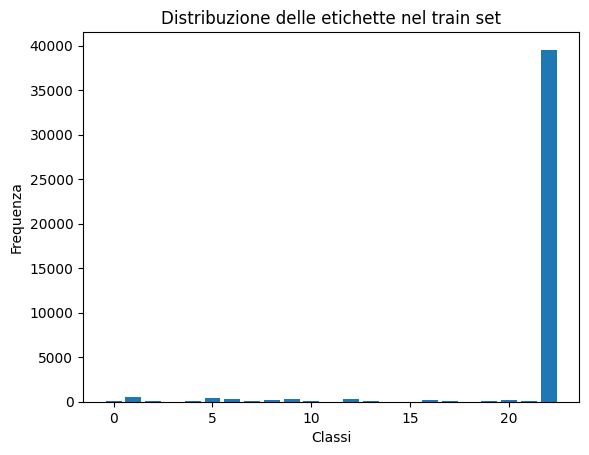

In [104]:
import matplotlib.pyplot as plt

# Distribuzione delle etichette nei dati di addestramento
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(unique, counts)
plt.title("Distribuzione delle etichette nel train set")
plt.xlabel("Classi")
plt.ylabel("Frequenza")
plt.show()


In [105]:
# Aggiungi un callback per tracciare il loss
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Grafico del loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss durante l'addestramento")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.show()


Epoch 1/10
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 392s 294ms/step - accuracy: 0.9251 - loss: 0.4917 - val_accuracy: 0.9225 - val_loss: 0.4765
Epoch 2/10
 212/1334 ━━━━━━━━━━━━━━━━━━━━ 5:23 288ms/step - accuracy: 0.9278 - loss: 0.4666

KeyboardInterrupt: 